IA & Data science (LU3IN0226) -- 2022-2023
--------
*&copy; Equipe pédagogique: Christophe Marsala, Olivier Schwander, Jean-Noël Vittaut.*

<font size="+1" color="RED"><b>[Q]</b></font> <font size="+1"><b>Indiquer dans la boîte ci-dessous vos noms et prénoms :</b></font>

*Double-cliquer ici et insérer les noms et prénoms de votre binôme*

Paul JARSKI

Neil BENAHMED

Ce projet peut être fait en binôme (d'un même groupe). Le nom de chaque membre du binôme doit être indiqué, et un seul rendu sur un des deux comptes Moodle doit être fait.

Les groupes de plus de 2 personnes ne sont pas autorisés.

<font color="RED" size="+1"><b>[Q]</b></font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>projet-1</tt> et rajouter à la suite de <tt>projet-1</tt> les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au notebook** : *projet-1-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme

**Le compte-rendu doit être rendu sur la page Moodle.**

# Projet 1 - février-mars 2023


<font size="+1" color="RED"><b>Date de rendu : jeudi 22 mars, 18h au plus tard</b></font>
<br />


Vous devez compléter ce notebook en rajoutant vos expérimentations avec vos algorithmes d'apprentissage sur les 2 datasets fournis dans le répertoire data-projet:
- les données data-2D.pkl : données en 2 dimensions, 2 labels
- les données data-5D.pkl : données en 5 dimensions, 2 labels

## Travail à faire

Pour chaque ensemble de données:
- les 3 algorithmes d'apprentissage knn, perceptron et perceptron biais doivent être expérimentés et comparés (ATTENTION: on ne veut que des algorithmes que vous avez implémentés vous-même dans cette UE).
- des résultats d'expérimentations doivent fournir une comparaison des taux de bonne classification apprentissage / test avec validation croisée en 10.
- des courbes (coût, poids, variation d'accuracy,...) doivent être fournies pour étudier les modèles construits.

Vos **expérimentations doivent être expliquées**... (utilisez des boîtes Markdown pour saisir vos explications):
- une argumentation du type *"pourquoi vous avez fait cette expérimentation"* doit être fournie;
- une analyse succincte du résultat fourni doit être aussi donnée.



Par exemple (indicatif): choix de $k$ pour le knn:
- argumentation : pour décider quelle peut être la valeur de $k$ optimale, on décide de tester plusieurs valeurs différentes et de comparer les taux de bonne classification sur la base de test obtenus.
- analyse du résultat: on remarque que la valeur $k$ suivante fournie le meilleur résultat.
- étude du temps d'exécution.


## Travail à rendre
Ce qui doit être rendu : un fichier archive (`.tar`, `.tgz`, ou `.zip` uniquement) contenant uniquement ce notebook, dans lequel vous avez reporté toutes les fonctions que vous utilisez : ce notebook doit pouvoir être exécuté sans autre apport (pensez à vous en assurer avant de le rendre). Les fichiers de données ne doivent pas être inclus dans votre archive !



## Lecture des pickles



In [2]:
# Importation de librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
from scipy.spatial import distance
from sklearn.utils import shuffle


%matplotlib inline

# Importation de la librairie pickle
import pickle as pkl

# lecture des donnéees en dimension 2 dans un dataframe pandas
data2D = pkl.load(open('data-projet/data-2D.pkl', 'rb')) 
X2D = np.array(data2D[['x1', 'x2']], dtype=float) # conversion de type pour une meilleure compatibilité
Y2D = np.array(data2D['label'], dtype=float)

# pour les données en dimension 5, la méthode est la même, modifier seulement les noms des colonnes
data5D = pkl.load(open('data-projet/data-5D.pkl','rb'))
X5D = np.array(data5D[['x1','x2','x3','x4','x5']], dtype=float)
Y5D = np.array(data5D['label'], dtype=float)


## Code de nos algorithmes implémentés :

### Classifieurs

In [3]:
class Classifier:
    """ Classe (abstraite) pour représenter un classifieur
        Attention: cette classe est ne doit pas être instanciée.
    """
    
    def __init__(self, input_dimension):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
            Hypothèse : input_dimension > 0
        """
        self.input_dimension = input_dimension
        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        raise NotImplementedError("Please Implement this method")
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")
        
    def accuracy(self, desc_set, label_set):
        """ Permet de calculer la qualité du système sur un dataset donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """
        cpt=0
        n = len(desc_set)
        predict_label = []
        for i in range(n):
            predict_label.append(self.predict(desc_set[i]))
        accuracy= np.mean(np.array(predict_label)==np.array(label_set))
        return accuracy  

In [4]:
class ClassifierKNN(Classifier):
    """ Classe pour représenter un classifieur par K plus proches voisins.
        Cette classe hérite de la classe Classifier
    """
    def __init__(self, input_dimension, k):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - k (int) : nombre de voisins à considérer
            Hypothèse : input_dimension > 0
        """
        self.input_dimension = input_dimension
        self.k = k
        
        
    def score(self,x):
        """ rend la proportion de +1 parmi les k ppv de x (valeur réelle)
            x: une description : un ndarray
        """
        #dist = [np.sqrt((x[0]-self.desc_set[i][0])**2+(x[1]-self.desc_set[i][1])**2) for i in range(len(self.desc_set))]
        distances = [distance.euclidean(desc, x) for desc in self.desc_set]
        top_k_indices = np.argsort(distances)[:self.k]
        p = sum(1 for i in top_k_indices if self.label_set[i] == 1) / self.k
        return 2 * (p - 0.5)

    
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
            x: une description : un ndarray
        """
        if self.score(x) > 0:
            return +1
        else:
            return -1 #on ne considère pas le cas score==0

        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        self.desc_set = desc_set
        self.label_set = label_set

In [5]:
class ClassifierPerceptron(Classifier):
    """ Perceptron de Rosenblatt
    """
    def __init__(self, input_dimension, learning_rate=0.01, init=True ):
        """ Constructeur de Classifier
            Argument:
                - input_dimension (int) : dimension de la description des exemples (>0)
                - learning_rate (par défaut 0.01): epsilon
                - init est le mode d'initialisation de w: 
                    - si True (par défaut): initialisation à 0 de w,
                    - si False : initialisation par tirage aléatoire de valeurs petites
        """
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        if init:
            self.w = np.zeros(self.input_dimension)
        else:
            self.w = np.asarray([(2*(np.random.uniform(0,1)) - 1)*0.0001 for i in range(input_dimension)])
        self.allw =[self.w.copy()]
        
        
    def train_step(self, desc_set, label_set):
        """ Réalise une unique itération sur tous les exemples du dataset
            donné en prenant les exemples aléatoirement.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
        """        
        desc_set2, label_set2 = shuffle(desc_set, label_set)
        for xi,yi in zip(desc_set2, label_set2):
            if self.predict(xi) != yi:
                self.w = self.w + self.learning_rate*yi*xi
                self.allw.append(self.w.copy())
                

    def train(self, desc_set, label_set, nb_max=100, seuil=0.001):
        """ Apprentissage itératif du perceptron sur le dataset donné.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
                - nb_max (par défaut: 100) : nombre d'itérations maximale
                - seuil (par défaut: 0.001) : seuil de convergence
            Retour: la fonction rend une liste
                - liste des valeurs de norme de différences
        """
        liste_difference=[]
        for i in range(nb_max):
            w_avant = self.w.copy()
            self.train_step(desc_set,label_set)
            difference = np.abs(self.w - w_avant)
            change = np.linalg.norm(difference)
            liste_difference.append(change)
            if change <= seuil:
                break
        return liste_difference
        
        
    def get_allw(self):
        return self.allw
            
        
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        return np.vdot(x,self.w)
    
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        return 1 if self.score(x) > 0 else -1

In [6]:
class ClassifierPerceptronBiais(ClassifierPerceptron):
    """ Perceptron de Rosenblatt avec biais
        Variante du perceptron de base
    """
    def __init__(self, input_dimension, learning_rate=0.01, init=True):
        """ Constructeur de Classifier
            Argument:
                - input_dimension (int) : dimension de la description des exemples (>0)
                - learning_rate (par défaut 0.01): epsilon
                - init est le mode d'initialisation de w: 
                    - si True (par défaut): initialisation à 0 de w,
                    - si False : initialisation par tirage aléatoire de valeurs petites
        """
        super().__init__(input_dimension, learning_rate, init)
        
        
    def train_step(self, desc_set, label_set):
        """ Réalise une unique itération sur tous les exemples du dataset
            donné en prenant les exemples aléatoirement.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
        """   
        n =  len(desc_set)       
        indexes =[i for i in range(n)]
        np.random.shuffle(indexes)
        desc_set2 = desc_set[indexes]
        label_set2 = label_set[indexes]
        for xi,yi in zip(desc_set2, label_set2):
            if self.score(xi)*yi <= 1:
                self.w = self.w + self.learning_rate*(yi - self.score(xi))*xi
                self.allw.append(self.w.copy())     

### Train-test split

In [7]:
def genere_train_test(desc_set, label_set, n_pos, n_neg):
    """ permet de générer une base d'apprentissage et une base de test
        desc_set: ndarray avec des descriptions
        label_set: ndarray avec les labels correspondants
        n_pos: nombre d'exemples de label +1 à mettre dans la base d'apprentissage
        n_neg: nombre d'exemples de label -1 à mettre dans la base d'apprentissage
        Hypothèses: 
           - desc_set et label_set ont le même nombre de lignes)
           - n_pos et n_neg, ainsi que leur somme, sont inférieurs à n (le nombre d'exemples dans desc_set)
    """    
    label_set_pos = label_set[label_set == +1]
    label_set_neg = label_set[label_set == -1]
    desc_set_pos = desc_set[label_set == + 1]
    desc_set_neg = desc_set[label_set == -1]
    
    ind_positif = random.sample([i for i in range(0,label_set_pos.shape[0])],len(label_set_pos))
    ind_negatif = random.sample([i for i in range(0,label_set_neg.shape[0])],len(label_set_neg))
    
    desc_set_pos = desc_set_pos[ind_positif]
    desc_set_neg = desc_set_neg[ind_negatif]
    
    label_set_pos = label_set_pos[ind_positif]
    label_set_neg = label_set_neg[ind_negatif]
    
    train_desc = np.concatenate((desc_set_pos[:n_pos],  desc_set_neg[:n_neg]),axis=0)
    train_label = np.concatenate((label_set_pos[:n_pos], label_set_neg[:n_neg]),axis=0) 
    test_desc =  np.concatenate((desc_set_pos[n_pos:], desc_set_neg[n_neg:]),axis=0)
    test_label = np.concatenate((label_set_pos[n_pos:], label_set_neg[n_neg:]),axis=0)

    return (train_desc, train_label), (test_desc, test_label)

### Validation croisée

In [8]:
def crossval_strat(X, Y, n_iterations, iteration):
    index_pos = [ i for i in range(len(Y)) if Y[i]==1]
    index_neg = [ i for i in range(len(Y)) if Y[i]== -1]

    index_pos_test = index_pos[iteration*(len(index_pos) // n_iterations ): (iteration+1)*(len(index_pos) // n_iterations) ]
    index_neg_test = index_neg[iteration*(len(index_neg) // n_iterations ): (iteration+1)*(len(index_neg) // n_iterations) ]
    
    Xtest = np.concatenate(( X[index_neg_test] , X[index_pos_test]  ))
    Ytest =  np.concatenate(( Y[index_neg_test] , Y[index_pos_test] ))
    
    index_app = [i for i in range(len(Y)) if ( (i not in index_pos_test) and (i not in index_neg_test) )]

    Xapp =  X[index_app]
    Yapp =  Y[index_app]
    return Xapp, Yapp, Xtest, Ytest

In [9]:
def analyse_perfs(L):
    """ L : liste de nombres réels non vide
        rend le tuple (moyenne, écart-type)
    """
    return (np.mean(L),np.std(L))

In [10]:
def validation_croisee_knn(niter, X, Y, dims, k):   
    index = np.random.permutation(X.shape[0]) # mélange des index
    X_melange = X[index]
    Y_melange = Y[index]
    perf = []
    for i in range(niter):
        Xapp,Yapp,Xtest,Ytest = crossval_strat(X_melange, Y_melange, niter, i)
        knn = ClassifierKNN(dims,k)
        knn.train(Xapp, Yapp)
        perf.append(knn.accuracy(Xtest, Ytest))
    return perf, analyse_perfs(perf)

In [80]:
def validation_croisee(C, DS, nb_iter):
    """ Classifieur * tuple[array, array] * int -> tuple[ list[float], float, float]
    """
    X, Y = DS   
    perf = []
    for i in range(nb_iter):
        Xapp,Yapp,Xtest,Ytest = crossval_strat(X,Y,nb_iter,i)
        classifier = copy.deepcopy(C)
        classifier.train(Xapp, Yapp)
        perf.append(classifier.accuracy(Xtest,Ytest))
        
    (perf_moy, perf_sd) = analyse_perfs(perf)
    return (perf, perf_moy, perf_sd)

### Cout

i.e. ce que le perceptron biais cherche à minimiser

In [12]:
# couts_vect est plus rapide grâce à la vectorisation des calculs

def couts(allw,X,Y):
    cout_liste = []
    for w in allw:
        cout = 0
        for xi,yi in zip(X,Y):    
            a = 1-np.dot(xi, w)*yi
            if (a > 0): 
                cout+=a
        cout_liste.append(cout)
    return cout_liste


def couts_vect(allw,X,Y):
    cout_liste = []
    for w in allw:
        alphas = np.ones(X.shape[0])
        alphas -= np.multiply(  np.matmul(X, np.transpose(w)) , Y)
        cout_liste.append(sum(alphas[alphas > 0]))
    return cout_liste

### Plotting

In [13]:
def plot2DSet(desc,labels):    
    """ ndarray * ndarray -> affichage
        la fonction doit utiliser la couleur 'red' pour la classe -1 et 'blue' pour la +1
    """
   #TODO: A Compléter    
    #raise NotImplementedError("Please Implement this method")
    neg = desc[labels == -1]
    pos = desc[labels == +1]
    plt.scatter(neg[:,0],neg[:,1],marker='o',color='red')
    plt.scatter(pos[:,0],pos[:,1],marker='x',color='blue')

def plot_frontiere(desc_set, label_set, classifier, step=30):
    """ desc_set * label_set * Classifier * int -> NoneType
        Remarque: le 4e argument est optionnel et donne la "résolution" du tracé: plus il est important
        et plus le tracé de la frontière sera précis.        
        Cette fonction affiche la frontière de décision associée au classifieur
    """
    mmax=desc_set.max(0)
    mmin=desc_set.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # calcul de la prediction pour chaque point de la grille
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # tracer des frontieres
    # colors[0] est la couleur des -1 et colors[1] est la couleur des +1
    plt.contourf(x1grid,x2grid,res,colors=["darksalmon","skyblue"],levels=[-1000,0,1000])


## CLASSIFIEUR KNN

### Données 2D

#### Estimation d'une bonne valeur de k
On teste ci-dessous de différentes valeurs de k.  À partir de k=5 le modèle est assez fiable.

On a trouvé que la fiabilité s'améliore jusqu'à k=130 environ, mais la différence n'est pas grande par rapport à k=5. 

In [20]:
#Parametres...à modifier
pourcentage_train = 0.7
k_max = 10  #max value de k à tester

In [21]:
#Code de génération du test-train split...pas à modifier
npos_total = Y2D[Y2D == +1].shape[0]
nneg_total = Y2D[Y2D == -1].shape[0]

npos_train = int(npos_total * pourcentage_train)
nneg_train = int(nneg_total * pourcentage_train)

(X_train, y_train), (X_test, y_test) = genere_train_test(X2D, Y2D, npos_train, nneg_train)


In [22]:
accuracies1 = []

for k in range(1,k_max+1):
    knn = ClassifierKNN(2,k)
    knn.train(X_train, y_train)
    acc = knn.accuracy(X_test, y_test)
    accuracies1.append(acc)
    

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

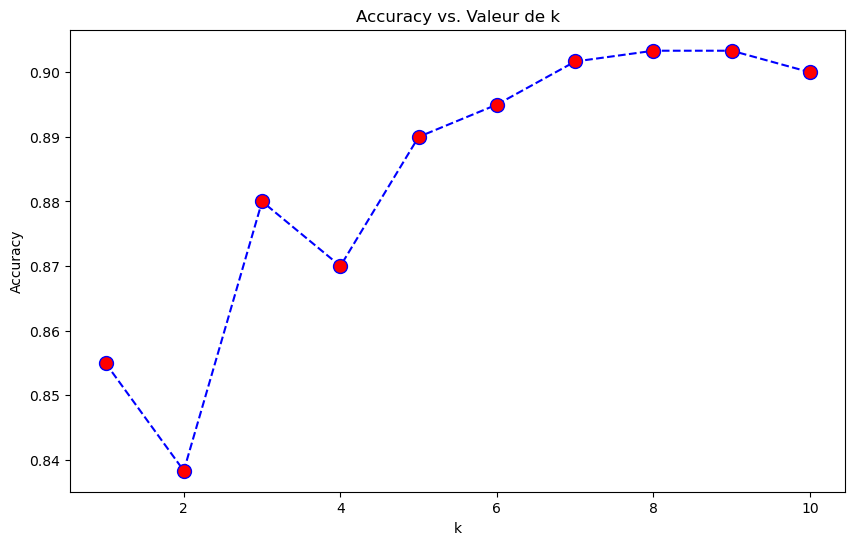

In [15]:
plt.figure(figsize=(10,6))
plt.plot(range(1,k_max+1),accuracies1,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. Valeur de k')
plt.xlabel('k')
plt.ylabel('Accuracy')


Le temps d'entraînement est négligeable.
Le temps de classification d'un nouveau point des données de test ne varie pas en fonction de k, mais plutôt en fonction de la taille des données d'entraînement (car il faut les trier selon leur distance du nouveau point).

D'abord on montre que la valeur de k n'a aucun effet sur le temps de calcul:

In [26]:
import time

range_of_k = range(1,10)
train_times = []
test_times = []

for k in range_of_k:
    knn = ClassifierKNN(2,k)

    start_train = time.time()
    knn.train(X_train, y_train)
    end_train = time.time()

    start_test = time.time()
    acc = knn.accuracy(X_test, y_test)
    end_test = time.time()

    train_times.append(end_train - start_train)
    test_times.append(end_test - start_test)


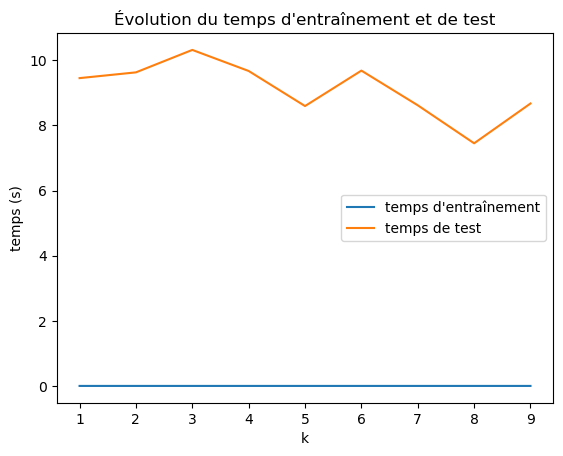

In [27]:
plt.figure()
plt.plot(range_of_k, train_times, label="temps d'entraînement") 
plt.plot(range_of_k, test_times, label="temps de test")
plt.title("Évolution du temps d'entraînement et de test")
plt.xlabel('k')
plt.ylabel('temps (s)')
plt.legend()

Puis on montre l'évolution du temps de prédiction en fonction de la taille des données d'entraînement:

In [137]:
import time

pourcentages_train = np.linspace(0.1,0.9,10)
k=5

npos_total = Y2D[Y2D == +1].shape[0]
nneg_total = Y2D[Y2D == -1].shape[0]

test_times_moyenne = []

for p in pourcentages_train:
    npos_train = int(npos_total * p)
    nneg_train = int(nneg_total * p)
    (X_train, Y_train), (X_test, Y_test) = genere_train_test(X2D, Y2D, npos_train, nneg_train)
    knn = ClassifierKNN(2,k)
    knn.train(X_train,Y_train)

    total_test_time = 0
    for x in X_test:
        start_test = time.time()
        knn.predict(x)
        end_test = time.time()
        total_test_time += (end_test - start_test)
    test_times_moyenne.append(total_test_time / len(X_test))



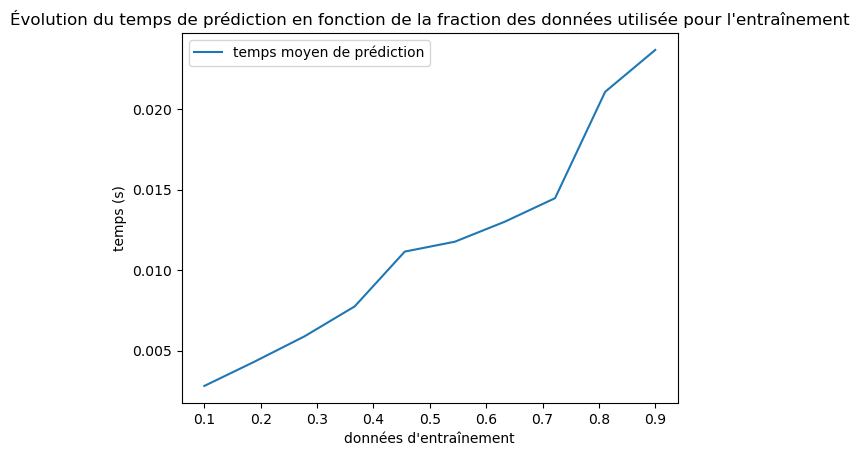

In [138]:
plt.figure()
plt.plot(pourcentages_train, test_times_moyenne, label="temps moyen de prédiction")
plt.title("Évolution du temps de prédiction en fonction de la fraction des données utilisée pour l'entraînement")
plt.xlabel("données d'entraînement")
plt.ylabel('temps (s)')
plt.legend()

#### Validation croisée

In [131]:
k=5
niter=10  

perf, (moy,ecart_type) = validation_croisee_knn(niter=niter, X=X2D, Y=Y2D, dims=2, k=k)

print(f"Validation croisée : \n\tk = {k}, niter = {niter}")
print(f"\tmoyenne = {moy}")
print(f"\tecart_type = {ecart_type}")


Validation croisée : 
	k = 5, niter = 10
	moyenne = 0.9175000000000001
	ecart_type = 0.0098107084351743


In [132]:
k=130
niter=10  

perf, (moy,ecart_type) = validation_croisee_knn(niter=niter, X=X2D, Y=Y2D, dims=2, k=k)

print(f"Validation croisée : \n\tk = {k}, niter = {niter}")
print(f"\tmoyenne = {moy}")
print(f"\tecart_type = {ecart_type}")

Validation croisée : 
	k = 130, niter = 10
	moyenne = 0.9244999999999999
	ecart_type = 0.02229910312097774


Le modèle pour k=5 est très fiable, un peu meilleur pour k=130 (la plupart du temps...parfois l'écart type devient légèrement plus grand).  La validation croisée montre que le modèle marche aussi bien sur des données de test que sur des données d'entraînement.

In [ ]:
# k=5
# niter = 10

# index = np.random.permutation(X2D.shape[0]) # mélange des index
# X2D_melange = X2D[index]
# Y2D_melange = Y2D[index]
# perf_5 = []
# for i in range(niter):
#     Xapp,Yapp,Xtest,Ytest = crossval_strat(X2D_melange, Y2D_melange, niter, i)
#     knn = ClassifierKNN(2,k)
#     knn.train(Xapp, Yapp)
#     perf_5.append(knn.accuracy(Xtest, Ytest))

In [47]:

# perfs = []
# moyennes = []
# ecart_types = []
# for i in range(5,11):
#     perf, (moy,ecart_type) = validation_croisee_knn(10, X2D, Y2D, 2, i)
#     perfs.append(perf)
#     moyennes.append(moy)
#     ecart_types.append(ecart_type)
   


    

Text(0, 0.5, 'écart type')

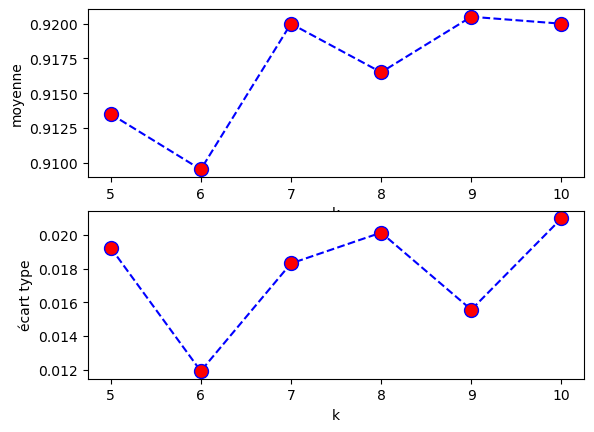

In [50]:
# fig, ax = plt.subplots(2,1)

# ax[0].plot(range(5,11),moyennes,color='blue', linestyle='dashed', marker='o',
#          markerfacecolor='red', markersize=10)
# ax[0].set_xlabel('k')
# ax[0].set_ylabel('moyenne')
# ax[1].plot(range(5,11),ecart_types,color='blue', linestyle='dashed', marker='o',
#          markerfacecolor='red', markersize=10)
# ax[1].set_xlabel('k')
# ax[1].set_ylabel('écart type')
    

In [51]:
# # on stocke les accuracies dans une liste :

# accuracies2 = []
# X2D_test = X2D[0:10]
# Y2D_test = Y2D[0:10]

# # seuil max des valeurs de k à regarder:
# seuil_k = 1
# # toutes les valeurs de k à regarder:
# valeurs_k = [k for k in range(1,seuil_k,2)]

# # ------------------------ A COMPLETER 

# for i in valeurs_k:
#     un_KNN3 = ClassifierKNN(2,i)
#     un_KNN3.train(X2D,Y2D)
#     accuracies2.append(un_KNN3.accuracy(X2D,Y2D))

# # ---------------------------------------------
# for i in range(0,len(valeurs_k)):
#     print("Accuracy pour ",valeurs_k[i],":",accuracies2[i])


### Données 5D

Pour le classifieur knn à 5 dimensions, on a fait des tests similaires pour trouver une bonne valeur de k, puis on a fait la validation croisée pour vérifier que le model généralise bien sur l'ensemble des données.

In [31]:
#Parametres...à modifier
pourcentage_train = 0.7
k_max = 50  #max value de k à tester

In [32]:
#Code de génération du test-train split...pas à modifier
npos_total = Y5D[Y5D == +1].shape[0]
nneg_total = Y5D[Y5D == -1].shape[0]

npos_train = int(npos_total * pourcentage_train)
nneg_train = int(nneg_total * pourcentage_train)

(X_train, Y_train), (X_test, Y_test) = genere_train_test(X5D, Y5D, npos_train, nneg_train)

In [33]:
#cellule lente
accuracies3 = []

for k in range(1,k_max+1):
    knn = ClassifierKNN(5,k)
    knn.train(X_train, Y_train)
    acc = knn.accuracy(X_test, Y_test)
    accuracies3.append(acc)
    

Text(0, 0.5, 'Accuracy')

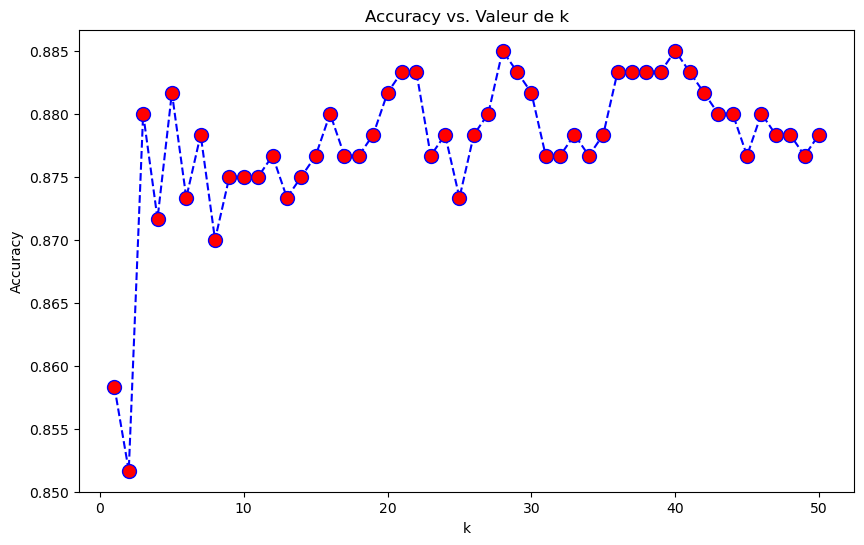

In [34]:
plt.figure(figsize=(10,6))
plt.plot(range(1,k_max+1),accuracies3,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. Valeur de k')
plt.xlabel('k')
plt.ylabel('Accuracy')

#### Validation croisée

In [134]:
#validation_croisee(C, DS, nb_iter)

ks = [5,50,100,150]
moys = []
sds = []
perfs = []

for k in ks:
    knn_vc = ClassifierKNN(5,k)
    perf, perf_moy, perf_sd = validation_croisee(knn_vc,(X5D,Y5D),10)
    moys.append(perf_moy)
    sds.append(perf_sd)
    perfs.append(perf)
    

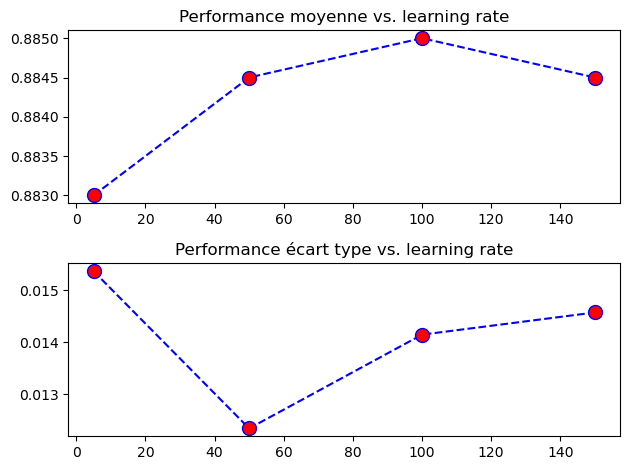

In [135]:
fig, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(ks,moys,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
ax[0].set_label("perf moyenne")
ax[0].set_title("Performance moyenne vs. learning rate")
ax[1].plot(ks,sds,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
ax[1].set_label("perf écart type")
ax[1].set_title("Performance écart type vs. learning rate")
fig.tight_layout()

## Perceptron : 

Avec le perceptron vu que contrairement au KNN il possède une étape d'entrainement, le but sera donc de trouver un nombre d'iteration d'entrainement convenable, ainsi que jouer avec les paramétre Learning-Rate, et l'initialisation des poids
, ainsi on pourra tester l'efficacité du modéle et savoir si il généralise d'une bonne maniére l'ensemble des données avec la validation croisées

### Données 2D 

In [38]:
npos_total = Y2D[Y2D == +1].shape[0]
nneg_total = Y2D[Y2D == -1].shape[0]

pourcentage_train = 0.7
npos_train = int(npos_total * pourcentage_train)
nneg_train = int(nneg_total * pourcentage_train)

(X_train, Y_train), (X_test, Y_test) = genere_train_test(X2D, Y2D, npos_train, nneg_train)


18
149
39
1000
908


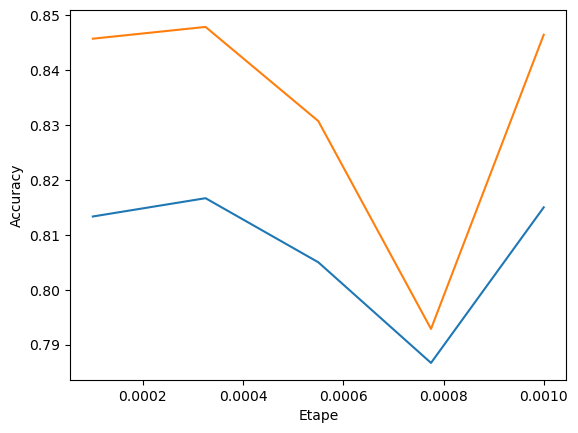

Accuracy finale (train):  0.8464285714285714
Accuracy finale (test) :  0.815


In [126]:

rates = np.linspace(0.0001,0.001,5)
train_acc = []
test_acc = []

for lr in rates:
    percep = ClassifierPerceptron(input_dimension = 2, learning_rate = lr, init = True)
    variations = percep.train(X_train, Y_train, nb_max=1000, seuil=0.0001)
    print(len(variations))
    train_acc.append(percep.accuracy(X_train, Y_train))
    test_acc.append(percep.accuracy(X_test,Y_test))

# -----
# Traçage de la courbe des variations d'accuracy
#plt.plot(rates,test_acc)  
plt.plot(rates, test_acc, rates, train_acc)
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.show()

# -----
# Affichage de la frontière de séparation des classes (en prenant tous les exemples de la base)
#plot_frontiere(X2D,Y2D,perceptron1,step=150)
#plot2DSet(X2D,Y2D)

print("Accuracy finale (train): ",  train_acc[-1])
print("Accuracy finale (test) : ", test_acc[-1])


Aprés avoir essayé plusieurs valeures de learning rate possible, on comprend rapidement que le learning rate ne changera pas grand chose, car le modéle n'arrive pas a classifier presque parfaitement les valeurs, on en conclut que les données ne sont pas classifiable lineairement, ou du moins pas avec une précision de 100%, cela dit, il donne quand meme des resultats assez convainquant jusqu'a 85% d'accuracy, il y'a quand meme assez d'overfitting, et le modéle n'arrie pas totalement a generaliser les données.

#### Validation croisée

In [121]:
#validation_croisee(C, DS, nb_iter)


c = ClassifierPerceptron(2, init=True)
perf, perf_moy, perf_sd = validation_croisee(c, (X2D,Y2D),10)

print("perf :",perf)
print("perf_moy :",perf_moy)
print("perf_sd :",perf_sd)


perf : [0.575, 0.835, 0.905, 0.79, 0.61, 0.735, 0.93, 0.78, 0.805, 0.93]
perf_moy : 0.7895
perf_sd : 0.11680004280821135


### Données 5D 

In [77]:
#Code de génération du test-train split...pas à modifier
npos_total = Y5D[Y5D == +1].shape[0]
nneg_total = Y5D[Y5D == -1].shape[0]

pourcentage_train = 0.7
npos_train = int(npos_total * pourcentage_train)
nneg_train = int(nneg_total * pourcentage_train)

(X_train, Y_train), (X_test, Y_test) = genere_train_test(X5D, Y5D, npos_train, nneg_train)

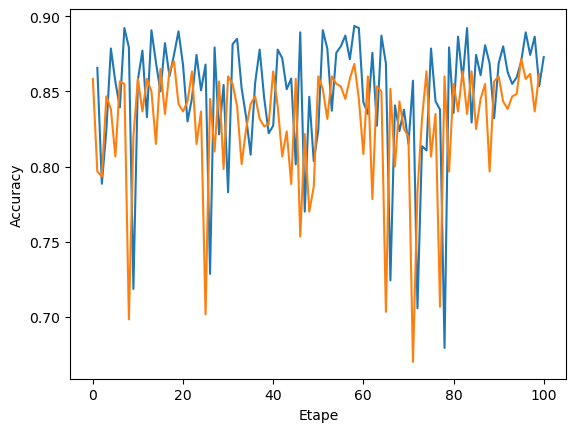

Accuracy finale (train):  0.8728571428571429
Accuracy finale (test) :  0.8616666666666667


In [78]:

N=100

perceptron1 = ClassifierPerceptron(input_dimension = 5,learning_rate = 0.01,init = True)


train_acc = []
test_acc = []

for i in range(N):
    perceptron1.train(X_train, Y_train)
    train_acc.append(perceptron1.accuracy(X_train, Y_train))
    test_acc.append(perceptron1.accuracy(X_test,Y_test))

# -----
# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.show()

# -----
# Affichage de la frontière de séparation des classes (en prenant tous les exemples de la base)
#plot_frontiere(X2D,Y2D,perceptron1,step=150)
#plot2DSet(X2D,Y2D)

print("Accuracy finale (train): ",  train_acc[-1])
print("Accuracy finale (test) : ", test_acc[-1])


#### Validation croisée

In [123]:
#validation_croisee(C, DS, nb_iter)


c = ClassifierPerceptron(5, init=True)
perf, perf_moy, perf_sd = validation_croisee(c, (X5D,Y5D),10)

print("perf :",perf)
print("perf_moy :",perf_moy)
print("perf_sd :",perf_sd)

perf : [0.83, 0.91, 0.775, 0.855, 0.855, 0.89, 0.865, 0.795, 0.845, 0.86]
perf_moy : 0.8480000000000001
perf_sd : 0.038223029707232785


# Perceptron biais :

### Données 2D 

In [76]:
pourcentage_train = 0.7


npos_total = Y2D[Y2D == +1].shape[0]
nneg_total = Y2D[Y2D == -1].shape[0]

npos_train = int(npos_total * pourcentage_train)
nneg_train = int(nneg_total * pourcentage_train)

(X_train, Y_train), (X_test, Y_test) = genere_train_test(X2D, Y2D, npos_train, nneg_train)


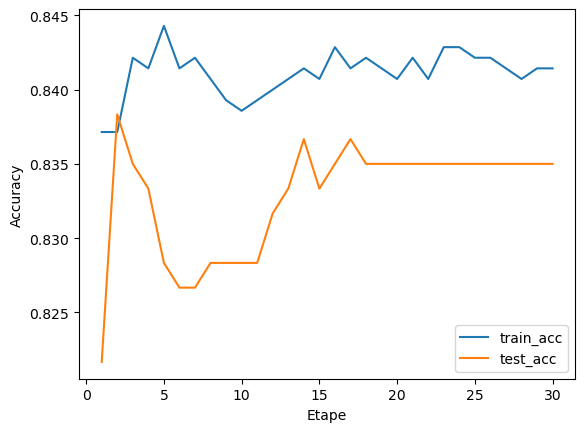

Accuracy finale (train):  0.8414285714285714
Accuracy finale (test) :  0.835


In [77]:


perceptron_biais1 = ClassifierPerceptronBiais(input_dimension=2, learning_rate=0.0001, init=True)
N = 30
train_acc = []
test_acc = []
for i in range(N):
    perceptron_biais1.train_step(X_train, Y_train)
    train_acc.append(perceptron_biais1.accuracy(X_train, Y_train))
    test_acc.append(perceptron_biais1.accuracy(X_test,Y_test))


# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc, label = "train_acc")
plt.plot(range(1,N+1), test_acc, label = "test_acc")  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.legend()
plt.show()

print("Accuracy finale (train): ",  train_acc[-1])
print("Accuracy finale (test) : ", test_acc[-1])


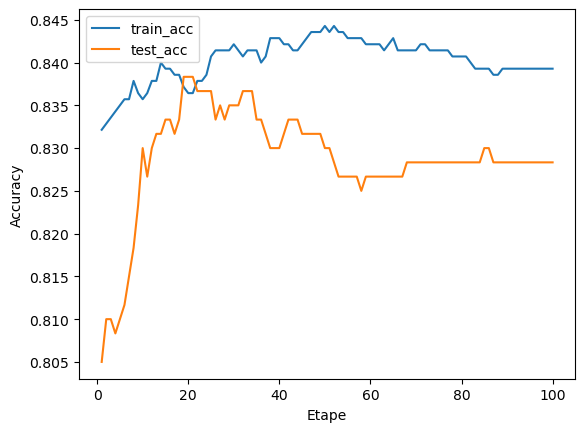

Accuracy finale (train):  0.8392857142857143
Accuracy finale (test) :  0.8283333333333334


In [78]:


perceptron_biais1 = ClassifierPerceptronBiais(input_dimension=2, learning_rate=0.00001, init=True)
N = 100
train_acc = []
test_acc = []
for i in range(N):
    perceptron_biais1.train_step(X_train, Y_train)
    train_acc.append(perceptron_biais1.accuracy(X_train, Y_train))
    test_acc.append(perceptron_biais1.accuracy(X_test,Y_test))


# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc, label = "train_acc")
plt.plot(range(1,N+1), test_acc, label = "test_acc")  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.legend()
plt.show()

print("Accuracy finale (train): ",  train_acc[-1])
print("Accuracy finale (test) : ", test_acc[-1])


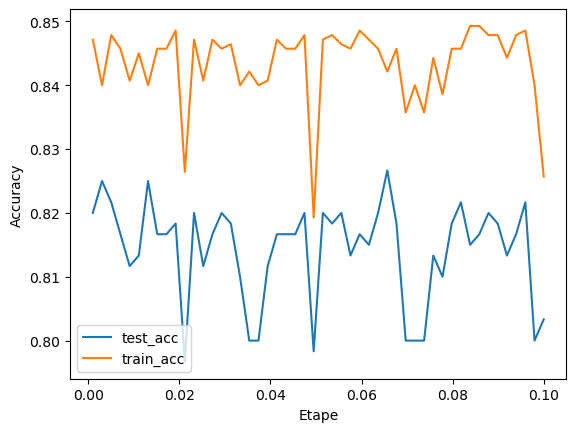

In [157]:
#rates = np.linspace(0.0001,0.001,50)
seuils = np.linspace(0.001, 0.1, 50)
train_acc = []
test_acc = []

#for lr in rates:
for s in seuils:
    percep = ClassifierPerceptronBiais(input_dimension = 2, learning_rate = 0.01, init = True)
    variations = percep.train(X_train, Y_train, nb_max=50, seuil=s)
    train_acc.append(percep.accuracy(X_train, Y_train))
    test_acc.append(percep.accuracy(X_test,Y_test))

plt.plot(seuils, test_acc, label="test_acc")
plt.plot(seuils, train_acc, label="train_acc")
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.legend()
plt.show()

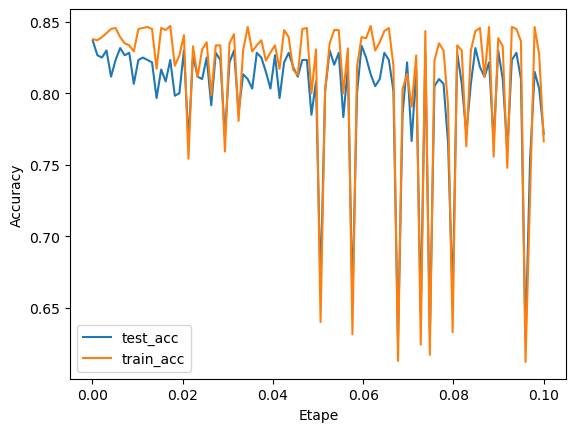

In [28]:
#rates = np.linspace(0.0001,0.001,50)
rates = np.linspace(0.0001, 0.1, 100)
train_acc = []
test_acc = []

#for lr in rates:
for lr in rates:
    percep = ClassifierPerceptronBiais(input_dimension = 2, learning_rate = lr, init = True)
    variations = percep.train(X_train, Y_train, nb_max=50)
    train_acc.append(percep.accuracy(X_train, Y_train))
    test_acc.append(percep.accuracy(X_test,Y_test))

plt.plot(rates, test_acc, label="test_acc")
plt.plot(rates, train_acc, label="train_acc")
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.legend()
plt.show()

Aprés le dernier test qui consiste à tester plusieurs valeurs de learning rate, ainsi que l'impact du learning rate sur un seul entraînement, on peut conclure que la valeur optimale du learning rate se situe aux alentours de 0.001, plus grand l'accuracy varie énormément et n'arrive pas à se stabiliser, et la généralisation est mauvaise, de même plus petit que 0.001, on remarque que l'accuracy augmente très bien pour le train, mais crée un overfitting pour les données de tests, on confirmera cela donc avec la validation croisée.

In [40]:
allw = np.array(perceptron1.get_allw())

allw_mod100 = allw[0::100] #il faut échantilloner, sinon temps de calcul énorme


cout_liste = couts_vect(allw_mod100,X_train,Y_train)

print(cout_liste)


[1400.0, 654.3696526405012, 579.9442686739096, 656.4859750130511, 634.3133524292219, 613.0389772388589, 631.4056516389311, 582.8974169902037, 625.9149673965919, 689.9226543825871, 594.1556492713677, 604.3723161637049, 655.9379368637241, 688.0744734518697, 647.9779622865486, 623.4876544564619, 680.4950571498381, 598.4892734184633, 601.2870168449141, 608.0053499969384, 608.3170769437021, 632.5658908049213, 650.2598261496219, 614.3655733931462, 603.91332167898, 708.1303869876277, 614.0533318952756, 671.8289548240022, 622.900582157731, 626.0544406135737, 652.9789551069675, 649.5685974251965, 629.9127799782389, 608.9385881235746, 607.611860311311, 698.7850395232854, 655.2823233359464, 591.4609734295104, 730.3504941893357, 649.2268574811284, 598.9043200839119, 588.6181765345946, 619.1343629170674, 585.5339797071352, 615.8544028203793, 595.7679650497541, 664.9328130832187, 670.4536587951454, 631.0840089498031, 591.5201568855164, 667.0215804705964, 673.774056228957, 654.8093313070923, 650.8676

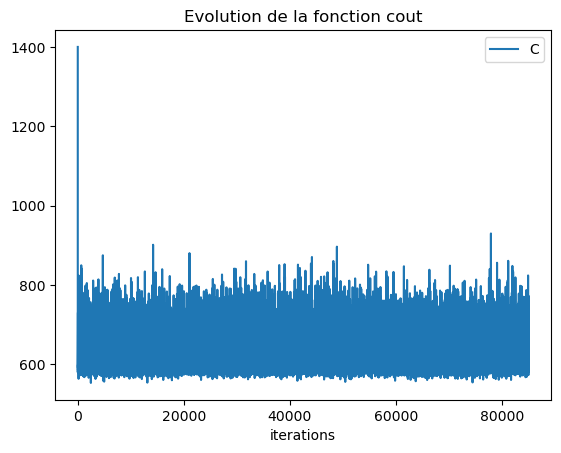

In [41]:
plt.figure()
plt.plot(cout_liste) # première coordonnée du vecteur poids: w1
plt.title('Evolution de la fonction cout')
plt.xlabel('iterations')
plt.legend(['C'])

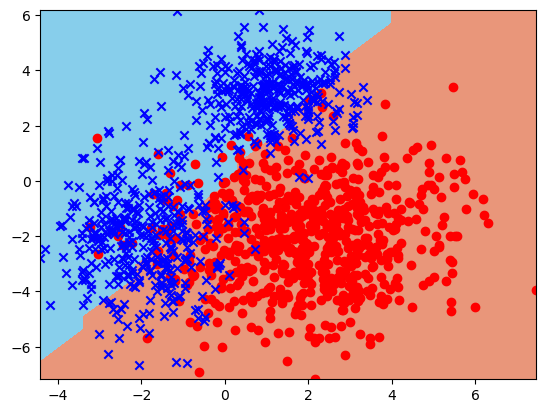

In [57]:

plot_frontiere(desc_set=X_train, label_set=Y_train, classifier=perceptron1, step=30)
plot2DSet(desc = X_train,labels = Y_train)


#### Validation croisée

In [127]:
#validation_croisee(C, DS, nb_iter)

rates = np.linspace(0.00001,0.1,10)

perfs = []
moys = []
sds = []

for lr in rates:
    c = ClassifierPerceptronBiais(2,learning_rate = lr , init=True)
    perf, perf_moy, perf_sd = validation_croisee(c, (X2D,Y2D),10)
    perfs.append(perf)
    moys.append(perf_moy)
    sds.append(perf_sd)

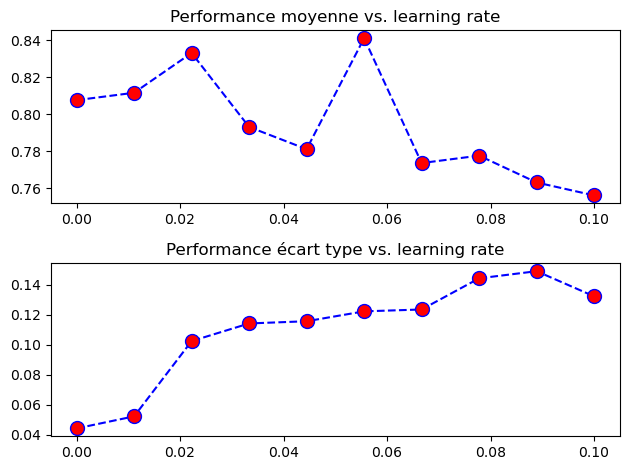

In [128]:
fig, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(rates,moys,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
ax[0].set_label("perf moyenne")
ax[0].set_title("Performance moyenne vs. learning rate")
ax[1].plot(rates,sds,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
ax[1].set_label("perf écart type")
ax[1].set_title("Performance écart type vs. learning rate")
fig.tight_layout()

### Données 5D 

In [58]:
#Code de génération du test-train split...pas à modifier
npos_total = Y5D[Y5D == +1].shape[0]
nneg_total = Y5D[Y5D == -1].shape[0]

npos_train = int(npos_total * pourcentage_train)
nneg_train = int(nneg_total * pourcentage_train)

(X_train, Y_train), (X_test, Y_test) = genere_train_test(X5D, Y5D, npos_train, nneg_train)

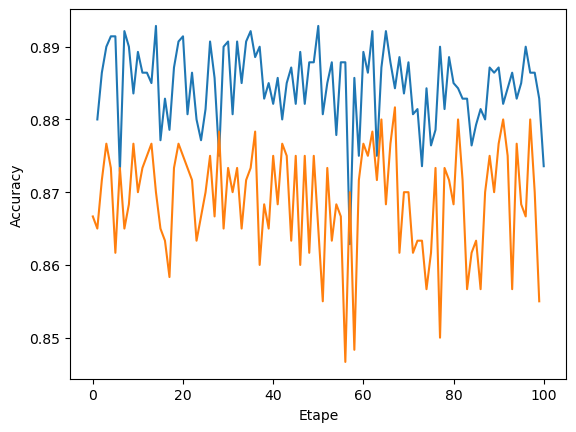

Accuracy finale (train):  0.8735714285714286
Accuracy finale (test) :  0.855


In [59]:
N=1

perceptron1 = ClassifierPerceptronBiais(input_dimension=5, learning_rate=0.01, init=True)

train_acc = []
test_acc = []

for i in range(N):
    perceptron1.train(X_train, Y_train)
    train_acc.append(perceptron1.accuracy(X_train, Y_train))
    test_acc.append(perceptron1.accuracy(X_test,Y_test))

# -----
# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.show()

# -----
# Affichage de la frontière de séparation des classes (en prenant tous les exemples de la base)
#plot_frontiere(X2D,Y2D,perceptron1,step=150)
#plot2DSet(X2D,Y2D)

print("Accuracy finale (train): ",  train_acc[-1])
print("Accuracy finale (test) : ", test_acc[-1])

In [65]:

# on considère les poids de perceptron_biais généré dans une boite précédente:
allw = np.array(perceptron1.get_allw()) 


allw_echantillonnage = allw[0::100000]  #échantillonage de allw.  Sinon cout_vect ne termine pas.
allw_echantillonnage.shape[0]


cout_liste = couts_vect(allw_echantillonnage,X_train,Y_train)

print(cout_liste)


[1400.0, 498.8126077696029, 471.9913073018264, 481.97395926938196, 498.8188797227757, 519.8532653537028, 458.01779153382074, 464.9561919453422, 487.01292712176536, 502.08788107658444, 496.58744251945365, 470.673555108207, 456.0816888355823, 466.7937049800204, 443.8146718370042, 503.9738013891772, 520.0163114557981, 483.0054180415735, 492.0367478423039, 484.62755444188514, 532.7440343912729, 449.95106539632934, 481.1196128250592, 499.6014796920466, 479.5326922526222, 468.0321474049597, 482.33105053457405, 439.23445687821106, 513.1171723741832, 447.4065929974697, 449.24798543661916, 483.3217644939646, 528.1247614171671, 499.8158669355589, 519.3615138741349, 506.99567346135063, 474.3193221012967, 480.8062885530248, 466.0051250242687, 502.9230675634553, 533.6959089065635, 491.6686769273508, 478.6434942954203, 482.90139247389624, 490.9391088306149, 489.84001816368556, 451.63372773471815, 529.14766391582, 503.97000897908595, 485.40687285611426, 504.6878522706197, 531.727321999471, 589.994207

In [108]:


plt.figure()
plt.plot(cout_liste) # première coordonnée du vecteur poids: w1
plt.title('Evolution de la fonction cout')
plt.xlabel('iterations')
plt.legend(['C'])
        

NameError: name 'cout_liste' is not defined

<Figure size 640x480 with 0 Axes>

In [124]:
pourcentage_train = 0.7


npos_total = Y2D[Y2D == +1].shape[0]
nneg_total = Y2D[Y2D == -1].shape[0]

npos_train = int(npos_total * pourcentage_train)
nneg_train = int(nneg_total * pourcentage_train)

(X_train, Y_train), (X_test, Y_test) = genere_train_test(X2D, Y2D, npos_train, nneg_train)

cpb = ClassifierPerceptronBiais(2,learning_rate=0.001, init=True)
variations = cpb.train(X_train, Y_train, nb_max = 200, seuil = 0.001)
accuracy = cpb.accuracy(X_test, Y_test)
print("accuracy:",accuracy)

cpb_allw = np.array(cpb.get_allw())
size_allw = cpb_allw.shape[0]





accuracy: 0.8216666666666667


In [125]:
couts_cpb = couts_vect(cpb_allw,X2D,Y2D)

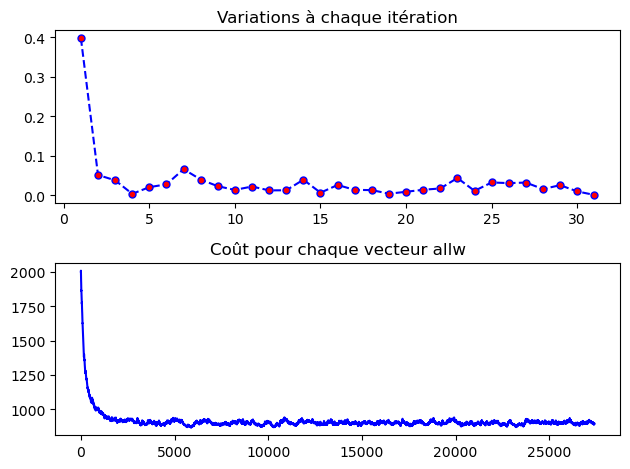

In [126]:
fig, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(range(1,len(variations)+1),variations,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=5)
ax[0].set_label("variations")
ax[0].set_title("Variations à chaque itération")
ax[1].plot(range(1,cpb_allw.shape[0]+1),couts_cpb,color='blue')
ax[1].set_label("perf écart type")
ax[1].set_title("Coût pour chaque vecteur allw")
fig.tight_layout()

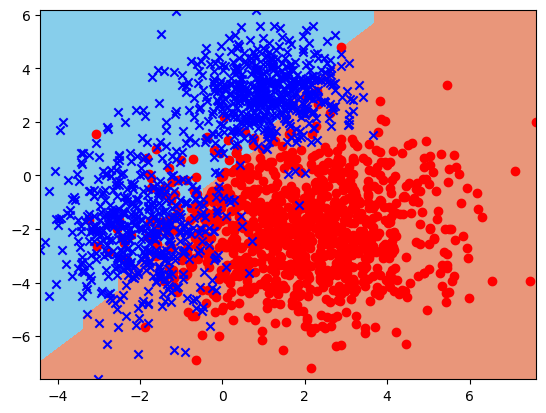

In [ ]:
plot_frontiere(desc_set=X2D, label_set=Y2D, classifier=cpb, step=30)
plot2DSet(desc = X2D,labels = Y2D)

#### Validation croisée

In [129]:
#validation_croisee(C, DS, nb_iter)

rates = np.linspace(0.00001,0.1,10)

perfs = []
moys = []
sds = []

for lr in rates:
    c = ClassifierPerceptronBiais(5,learning_rate = lr , init=True)
    perf, perf_moy, perf_sd = validation_croisee(c, (X5D,Y5D),10)
    perfs.append(perf)
    moys.append(perf_moy)
    sds.append(perf_sd)



#print(perfs)
#print("perf_moy :",perf_moy)
#print("perf_sd :",perf_sd)







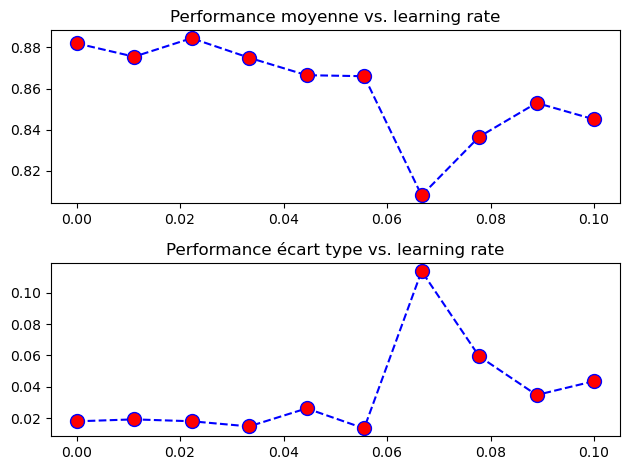

In [130]:
fig, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(rates,moys,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
ax[0].set_label("perf moyenne")
ax[0].set_title("Performance moyenne vs. learning rate")
ax[1].plot(rates,sds,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
ax[1].set_label("perf écart type")
ax[1].set_title("Performance écart type vs. learning rate")
fig.tight_layout()



lr 0.01 
[0.735, 0.785, 0.81, 0.86, 0.7, 0.735, 0.845, 0.815, 0.955, 0.9]
perf_moy : 0.8140000000000001
perf_sd : 0.07529276193632427

lr 0.0001 : 
[0.755, 0.785, 0.82, 0.785, 0.78, 0.76, 0.845, 0.835, 0.865, 0.87]
perf_moy : 0.8099999999999999
perf_sd : 0.04031128874149273

lr 